In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [9]:
# Set random seed for reproducibility
torch.manual_seed(42)

# VAE Architecture
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [10]:
# Loss function
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    return train_loss / len(train_loader.dataset)

# Create noisy images for anomaly testing
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    return torch.clamp(noisy_images, 0., 1.)

# Calculate reconstruction error
def reconstruction_error(model, data):
    model.eval()
    with torch.no_grad():
        data = data.view(data.size(0), -1)
        recon_data, _, _ = model(data)
        error = F.mse_loss(recon_data, data, reduction='none').sum(dim=1)
    return error

Epoch 1, Average loss: 170.9146
Epoch 2, Average loss: 125.5134
Epoch 3, Average loss: 117.0489
Epoch 4, Average loss: 112.6530
Epoch 5, Average loss: 109.7870
Epoch 6, Average loss: 107.5855
Epoch 7, Average loss: 106.1497
Epoch 8, Average loss: 105.0926
Epoch 9, Average loss: 104.2334
Epoch 10, Average loss: 103.5483
Epoch 11, Average loss: 102.9706
Epoch 12, Average loss: 102.4437
Epoch 13, Average loss: 102.0081
Epoch 14, Average loss: 101.6347
Epoch 15, Average loss: 101.2952
Epoch 16, Average loss: 100.9937
Epoch 17, Average loss: 100.7036
Epoch 18, Average loss: 100.4240
Epoch 19, Average loss: 100.2622
Epoch 20, Average loss: 99.9894
Anomaly threshold: 21.7022


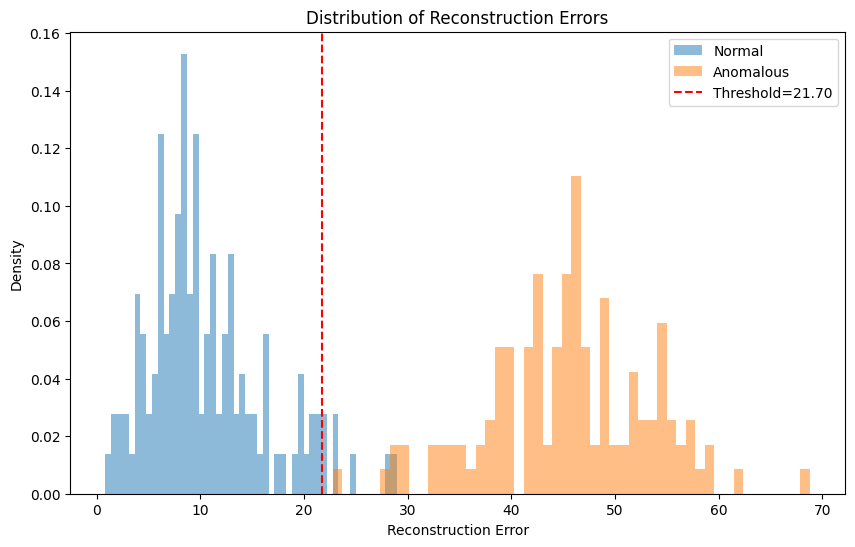

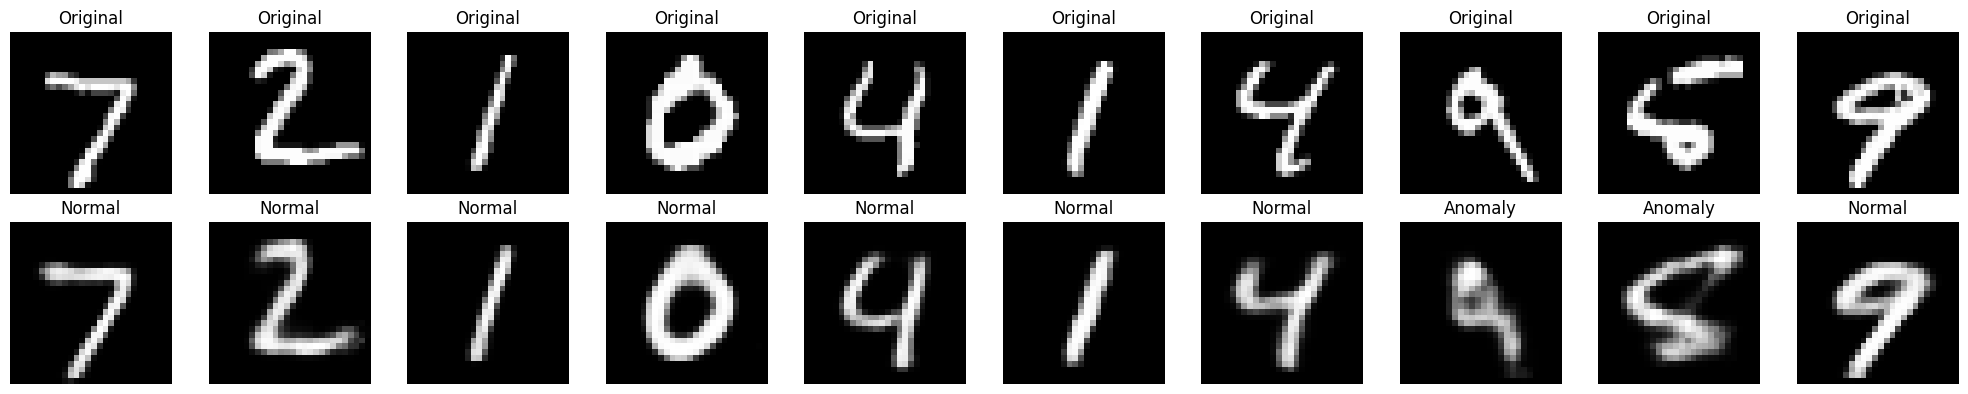

In [15]:
# Main training and evaluation
def main():
    # Hyperparameters
    batch_size = 128
    epochs = 20
    learning_rate = 1e-3
    latent_dim = 20
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model and optimizer
    model = VAE(latent_dim=latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, epoch)
        print(f'Epoch {epoch}, Average loss: {loss:.4f}')
    
    # Generate anomalous data
    normal_images = next(iter(test_loader))[0]
    anomalous_images = add_noise(normal_images, noise_factor=0.2)
    
    # Calculate reconstruction errors
    normal_errors = reconstruction_error(model, normal_images)
    anomalous_errors = reconstruction_error(model, anomalous_images)

    # Set threshold based on percentile of normal reconstruction errors
    threshold = np.percentile(normal_errors.numpy(), 95)  # 95th percentile
    print(f'Anomaly threshold: {threshold:.4f}')
    
    # Plot reconstruction error distributions
    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors.numpy(), bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(anomalous_errors.numpy(), bins=50, alpha=0.5, label='Anomalous', density=True)
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold={threshold:.2f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.show()
    
    # Example of using the threshold
    test_images = next(iter(test_loader))[0][:10]  # Get 10 test images
    test_errors = reconstruction_error(model, test_images)
    predictions = (test_errors > threshold).float()
    
    # Visualize some results
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        # Original images
        axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        # Reconstructed images
        with torch.no_grad():
            recon = model(test_images[i].view(1, -1))[0].view(28, 28)
        axes[1, i].imshow(recon.squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'{"Anomaly" if predictions[i] else "Normal"}')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()